В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/edce80b5bb02479085855b2334b17fc1). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [33]:
import pandas as pd
raw_df = pd.read_csv('../csv/train.csv', index_col=0)  # оскільки в наборі даних є колонка id - варто одразу її зчитати як індекс датасета
raw_df = raw_df.drop('Surname', axis=1)

from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(raw_df, test_size=0.2, random_state=42, stratify=raw_df['Exited'])

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12000 entries, 7180 to 9360
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       12000 non-null  float64
 1   CreditScore      12000 non-null  float64
 2   Geography        12000 non-null  object 
 3   Gender           12000 non-null  object 
 4   Age              12000 non-null  float64
 5   Tenure           12000 non-null  float64
 6   Balance          12000 non-null  float64
 7   NumOfProducts    12000 non-null  float64
 8   HasCrCard        12000 non-null  float64
 9   IsActiveMember   12000 non-null  float64
 10  EstimatedSalary  12000 non-null  float64
 11  Exited           12000 non-null  float64
dtypes: float64(10), object(2)
memory usage: 1.2+ MB


2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [34]:
input_cols = list(train_df.columns)[1: -1]
target_col = 'Exited'

train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]

3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [35]:
import numpy as np

numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = val_inputs.select_dtypes(include='object').columns.tolist()

4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

In [36]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 0 to 14999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       15000 non-null  float64
 1   CreditScore      15000 non-null  float64
 2   Geography        15000 non-null  object 
 3   Gender           15000 non-null  object 
 4   Age              15000 non-null  float64
 5   Tenure           15000 non-null  float64
 6   Balance          15000 non-null  float64
 7   NumOfProducts    15000 non-null  float64
 8   HasCrCard        15000 non-null  float64
 9   IsActiveMember   15000 non-null  float64
 10  EstimatedSalary  15000 non-null  float64
 11  Exited           15000 non-null  float64
dtypes: float64(10), object(2)
memory usage: 1.5+ MB


In [37]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

scaler = MinMaxScaler()
train_inputs[numeric_cols] = scaler.fit_transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(train_inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
print(encoded_cols)
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])

pd.set_option('display.max_columns', None)
display(train_inputs[:5], val_inputs[:5])

['Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male']


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
id,,,,,,,,,,,,,,,
7180,0.599045,France,Male,0.214286,0.1,0.626382,0.000000,1.0,1.0,0.719772,1.0,0.0,0.0,0.0,1.0
10393,0.603819,France,Female,0.375000,0.2,0.848836,0.000000,1.0,0.0,0.727603,1.0,0.0,0.0,1.0,0.0
80,0.653938,Germany,Male,0.303571,0.6,0.554522,0.333333,1.0,0.0,0.872180,0.0,1.0,0.0,0.0,1.0
3365,0.568019,Spain,Male,0.714286,0.0,0.000000,0.333333,0.0,1.0,0.257797,0.0,0.0,1.0,0.0,1.0
12236,0.658711,France,Male,0.053571,0.3,0.000000,0.333333,1.0,1.0,0.742837,1.0,0.0,0.0,0.0,1.0


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
id,,,,,,,,,,,,,,,
6490,0.675418,Germany,Male,0.500000,0.1,0.551870,1.000000,1.0,1.0,0.364704,0.0,1.0,0.0,0.0,1.0
3646,0.386635,France,Male,0.410714,0.5,0.000000,0.333333,1.0,1.0,0.190942,1.0,0.0,0.0,0.0,1.0
5306,0.715990,France,Female,0.357143,0.2,0.000000,0.333333,0.0,1.0,0.584853,1.0,0.0,0.0,1.0,0.0
652,0.577566,France,Female,0.446429,0.4,0.742441,0.000000,0.0,1.0,0.558109,1.0,0.0,0.0,1.0,0.0
2627,0.589499,Spain,Female,0.214286,0.4,0.000000,0.333333,1.0,0.0,0.718420,0.0,0.0,1.0,1.0,0.0


5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [38]:
train_inputs.to_parquet('train_inputs.parquet')
val_inputs.to_parquet('val_inputs.parquet')
pd.DataFrame(train_targets).to_parquet('train_targets.parquet')
pd.DataFrame(val_targets).to_parquet('val_targets.parquet')

import os
os.listdir()

['HW_2_2_Логістична_регресія_з_scikit_learn_Solution.ipynb',
 'train_targets.parquet',
 'log_reg.joblib',
 'train_inputs.parquet',
 'val_inputs.parquet',
 'HW_2_2_Логістична_регресія_з_scikit_learn.ipynb',
 'val_targets.parquet']

6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [39]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear')
model.fit(X_train, train_targets)

LogisticRegression(solver='liblinear')

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc

def get_metrics(model, inputs, targets, name=''):
    preds = model.predict(inputs)

    print(f"F1-score: {f1_score(targets, preds):.2f}")

    fpr, tpr, _ = roc_curve(targets, preds)
    roc_auc = auc(fpr, tpr)
    print(f"ROC AUC: {roc_auc:.2f}")

    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))

F1-score: 0.64
ROC AUC: 0.75


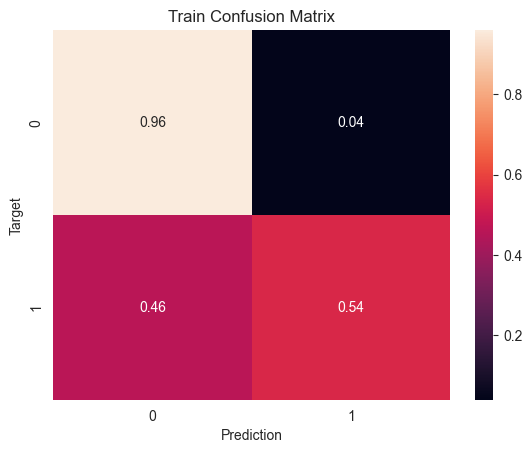

In [41]:
get_metrics(model, train_inputs[numeric_cols + encoded_cols], train_targets, 'Train')

F1-score: 0.64
ROC AUC: 0.76


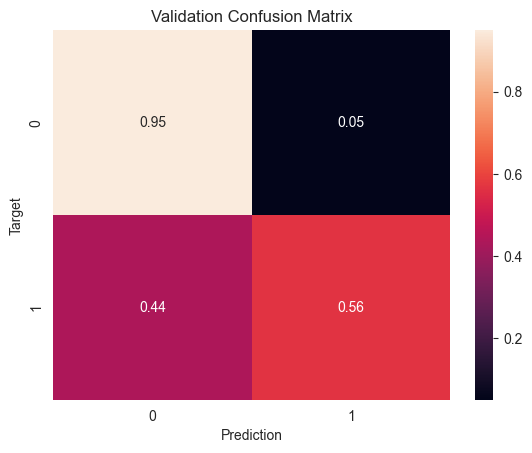

In [42]:
get_metrics(model, val_inputs[numeric_cols + encoded_cols], val_targets, 'Validation')

F1 має значення близькі на train і val наборах - це добрий знак. Також, F1 - не нуль, що вже каже, що модель робить кориснішу роботу, за передбачення всіх значень одним (найбільшим) класом :)

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [43]:
def all_no(inputs):
    return np.full(len(inputs), 0)

from sklearn.metrics import accuracy_score

# all_no model
print(accuracy_score(train_targets, all_no(X_train)))
print(accuracy_score(val_targets, all_no(X_val)))

0.7965
0.7966666666666666


In [44]:
# trained model
print(accuracy_score(train_targets, model.predict(X_train)))
print(accuracy_score(val_targets, model.predict(X_val)))

0.87425
0.8716666666666667


9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [45]:
import joblib

objects_to_save = {
    'model': model,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

joblib.dump(objects_to_save, 'log_reg.joblib')

['log_reg.joblib']

In [46]:
model_2 = joblib.load('log_reg.joblib')

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [47]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, input_df: pd.DataFrame):
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    prob = model.predict_proba(X_input)[:,1]
    return prob

In [48]:
predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, raw_df[:5])

array([0.00654092, 0.0366679 , 0.37111937, 0.37653484, 0.97577854])

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [49]:
test_raw_df = pd.read_csv('../csv/test.csv')
test_raw_df['Exited'] = predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, test_raw_df)

12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [50]:
submission = pd.read_csv('../csv/sample_submission.csv')
submission['Exited'] = test_raw_df['Exited']
submission.to_csv('../csv/submission_log_reg.csv', index=False)
submission['Exited'].head()

0    0.075316
1    0.035366
2    0.153210
3    0.194872
4    0.055660
Name: Exited, dtype: float64